# Plant Seedlings Classification

### A simple notebook explaning step by step how to perform image classification using convolutional neural networks and keras

### The data for this notebook can be found at https://www.kaggle.com/c/plant-seedlings-classification

#### First things first, we are going to be working with train.zip and test.zip datasets. We will need to transform the datasets a bit in order to use keras, specifically we will initially split the train examples into 3 separate sets

* Train set (80% of the data)
* Validation set (10% of the data)
* Fake-test set (10% of the data)

Why the fake-test set? well, it will give us an opportunity to know for sure whether or not we have overfitted train and validation sets. 

In addition to that, we will also use the test set that will be directly sourced from the files in test.zip

IMPORTANT, when uncompressing the files, put them into a directory named ```raw```, you can simply uncompress it into a train directory and later rename it to ```raw```

So here's how the file structure looks like for the train.zip files.

```
├── Black-grass
│   ├── 129c51855.png
│   ├── a08892355.png
│   └── f84089a55.png
├── Charlock
│   ├── 0d5f555a3.png
│   ├── 20b955bc3.png
│   └── d9de67550.png
├── Cleavers
│   ├── 0f557bb1a.png
│   ├── 2559137f2.png
│   ├── d4552e3f6.png
│   └── d55caa949.png
├── Common Chickweed
│   ├── 34455bf75.png
│   ├── 4825503ed.png
│   ├── fa468d955.png
│   └── ffc02550b.png
├── Common wheat
│   ├── 554ec08a6.png
│   ├── 597d0557e.png
│   ├── a1f2c5550.png
│   └── b8525b55d.png
├── Fat Hen
│   ├── 066395555.png
│   ├── 08fe5538d.png
│   ├── e27bb5522.png
│   └── f3f6559bf.png
├── Loose Silky-bent
│   ├── 1f8562553.png
│   ├── 25c91550e.png
│   └── e55c8ded3.png
├── Maize
│   ├── 18b6755a1.png
│   ├── 55083690a.png
│   └── ff4b55219.png
├── Scentless Mayweed
│   ├── 025155400.png
│   ├── 126d55392.png
│   ├── 133553324.png
│   ├── e07e7b55b.png
│   └── fa55f4be4.png
├── Shepherds Purse
│   ├── 1022cc155.png
│   ├── 42556bc41.png
│   ├── 670b97558.png
│   └── f38565506.png
├── Small-flowered Cranesbill
│   ├── 04559c69c.png
│   ├── 055922489.png
│   ├── c9fa2e553.png
│   ├── f1196e55f.png
│   └── f46902555.png
└── Sugar beet
    ├── 5255463b3.png
    ├── 54f1ef55a.png
    ├── 5582aca59.png
    ├── d558ea002.png
    ├── f40d6554c.png
    └── ffa401155.png
```

So remember, we are going to be working with 12 classes, which are 

* Black-grass
* Charlock
* Cleavers
* Common Chickweed
* Common wheat
* Fat Hen
* Loose Silky-bent
* Maize
* Scentless Mayweed
* Shepherds Purse
* Small-flowered Cranesbill
* Sugar beet

The current data structure is not convenient, as we really need something like

```
train
    ├── Black-grass
    │   ├── 129c51855.png
    │   ├── a08892355.png
    │   └── f84089a55.png
    ├── Charlock
    │   ├── 0d5f555a3.png
    │   ├── 20b955bc3.png
    │   └── d9de67550.png
    ├── Cleavers
    ├── ... the rest of the classes 
    │
validation
    │
    ├── Black-grass
    │   ├── 1.png
    │   ├── 2.png
    │   └── 3.png
    ├── Charlock
    │   ├── 4.png
    │   ├── 5.png
    │   └── 6.png
    ├── Cleavers
    ├── ... the rest of the classes  
    |
fake-test
    |
    │
    ├── Black-grass
    │   ├── a.png
    │   ├── b.png
    │   └── c.png
    ├── Charlock
    │   ├── a.png
    │   ├── b.png
    │   └── c.png
    ├── Cleavers
    ├── ... the rest of the classes     
```

The reason we need such structure is because later we will make use of Kera's ImageGenerator object, which requires different dirs for train and validation sets.

So, first things, first, we are going to prepare our data

In [102]:
from os import listdir
from os import mkdir
from os import makedirs
import os
import shutil
from IPython.display import Image, display
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16, vgg19
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model
from keras import optimizers


%matplotlib inline


In [84]:
# This code will require GPU usage... so sometimes we will need to run it in floydhub
FLOYDHUB=False
if FLOYDHUB:
    OUTPUT_DIR = "/output/"
    TRAIN_DIR = "/input/train/"
    VALIDATION_DIR = "/input/validation/"
    FAKE_TEST_DIR = "/input/fake-test"
    TEST_DIR = "/input/test"
else:
    OUTPUT_DIR = "/tmp/"
    TRAIN_DIR = "train/"
    VALIDATION_DIR = "validation/"
    FAKE_TEST_DIR = "fake-test/"
    TEST_DIR = "test/"

# As per the image size we will use, I am going with 224... no particular reason really
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224


In [85]:
CLASS_NAMES = [
    "Black-grass",
    "Charlock",
    "Cleavers",
    "Common Chickweed",
    "Common wheat",
    "Fat Hen",
    "Loose Silky-bent",
    "Maize",
    "Scentless Mayweed",
    "Shepherds Purse",
    "Small-flowered Cranesbill",
    "Sugar beet",
]

In [86]:
def prepare_data(train_size=0.8, validation_size=0.1, fake_test_size=0.1):
    """
    A simple code which will essentiall go into the "raw" directory and then read images from there and move 
    them into the TRAIN_DIR, VALIDATION_DIR and FAKE_TEST_DIR.
    """
    
    # First, lets create all the dirs we need.
    try:
        for class_name in CLASS_NAMES:
            makedirs(TRAIN_DIR+class_name, exist_ok=True)
            makedirs(VALIDATION_DIR+class_name, exist_ok=True)
            makedirs(FAKE_TEST_DIR+class_name, exist_ok=True)
    except Exception as e:
        print(e)
        pass
    
    # Now lets dive into each of the class directories of the "raw" directory
    for current_class in CLASS_NAMES:
        current_dir = "raw/"+current_class
        print("-----------------------------------")
        print("Now checking", current_dir)
        image_files = listdir(current_dir)
        total_files = len(image_files)
        index = 0
        total_images_train = 0
        total_images_validation = 0
        total_images_fake_test = 0
        
        for image_file in image_files:
            if index <= total_files * train_size: # This image will go to the train set
                total_images_train += 1
                shutil.copyfile(current_dir+"/"+image_file, TRAIN_DIR+current_class+"/"+image_file)
            elif index <= total_files * (train_size + validation_size): # This will go to the validation set
                total_images_validation += 1
                shutil.copyfile(current_dir+"/"+image_file, VALIDATION_DIR+current_class+"/"+image_file)
            else: # The rest will go to the fake test set
                total_images_fake_test +=1
                shutil.copyfile(current_dir+"/"+image_file, FAKE_TEST_DIR+current_class+"/"+image_file)
                
        
            index += 1
        
        print("There where a total of", total_files)
        print(total_images_train, "go to train set")
        print(total_images_validation, "go to validation set")
        print(total_images_fake_test, "go to the fake test set")

In [87]:
prepare_data()

-----------------------------------
Now checking raw/Black-grass
There where a total of 262
210 go to train set
26 go to validation set
26 go to the fake test set
-----------------------------------
Now checking raw/Charlock
There where a total of 390
313 go to train set
39 go to validation set
38 go to the fake test set
-----------------------------------
Now checking raw/Cleavers
There where a total of 287
230 go to train set
29 go to validation set
28 go to the fake test set
-----------------------------------
Now checking raw/Common Chickweed
There where a total of 611
489 go to train set
61 go to validation set
61 go to the fake test set
-----------------------------------
Now checking raw/Common wheat
There where a total of 221
177 go to train set
22 go to validation set
22 go to the fake test set
-----------------------------------
Now checking raw/Fat Hen
There where a total of 475
381 go to train set
47 go to validation set
47 go to the fake test set
--------------------------

### Lets show a couple of images...

train/Black-grass/0dad57e7f.png


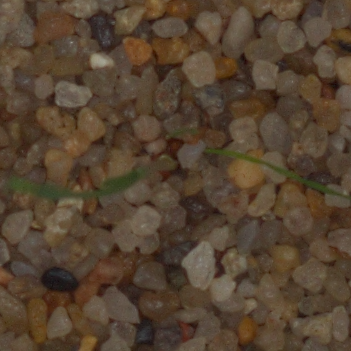

train/Charlock/c7ac56c83.png


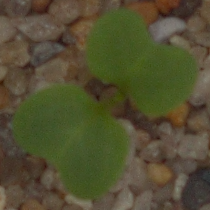

train/Cleavers/1e0caafd3.png


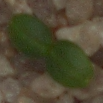

train/Common Chickweed/096eb593d.png


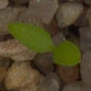

train/Common wheat/0df5ee8a2.png


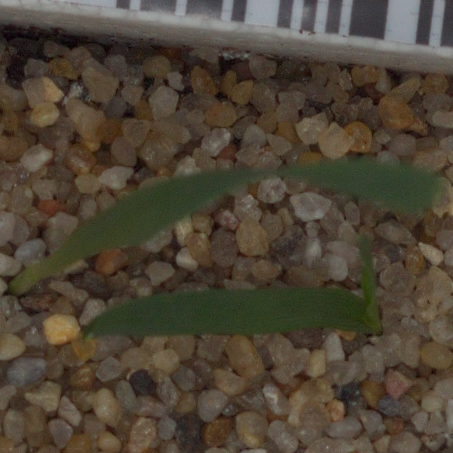

train/Fat Hen/fdc1eedc6.png


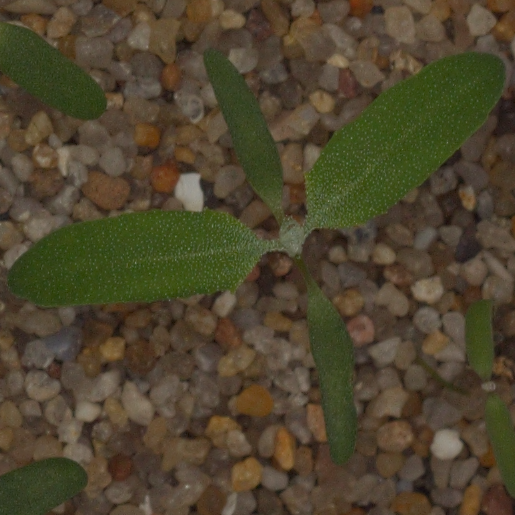

train/Loose Silky-bent/a7467a0ae.png


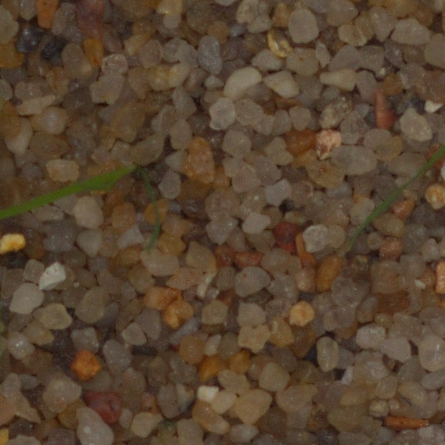

train/Maize/988113525.png


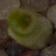

train/Scentless Mayweed/b7b392448.png


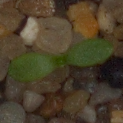

train/Shepherds Purse/270bc051c.png


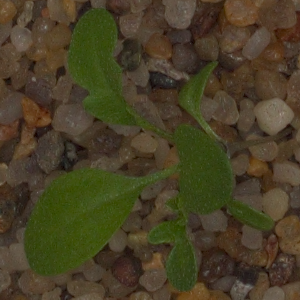

train/Small-flowered Cranesbill/c629f1db5.png


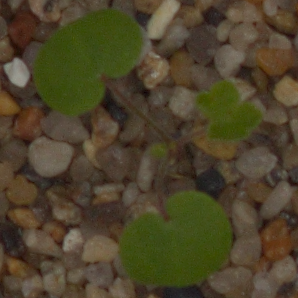

train/Sugar beet/c833940d5.png


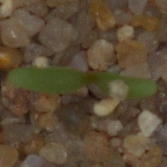

In [80]:
for my_class in CLASS_NAMES:
    current_dir = TRAIN_DIR+my_class
    for file in listdir(current_dir):
        image_file = TRAIN_DIR+my_class+"/"+file
        print(TRAIN_DIR+my_class+"/"+file)
        
        # Notice! The images have different sizes, so lets make sure we display them the same way...
        display(Image(filename=image_file, width=200, height=200))
        break


### As a fun note I will mention that so far all those pictures look very similar to me... I am pretty sure a farmer can easily tell the difference because he will have expertise in that area, but I do not. I wonder how good can machine learning get at this :) lets aim for 80% accuracy

### Lets get our ImageGenerator ready!

In [88]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# and the same for the test set
fake_test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  # this is the target directory
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use categorical_crossentropy loss, we will need one-hot-encoded...

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical')

# And the generator for test data
fake_test_generator = fake_test_datagen.flow_from_directory(
        FAKE_TEST_DIR,
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical')

Found 3805 images belonging to 12 classes.
Found 474 images belonging to 12 classes.
Found 470 images belonging to 12 classes.


In [111]:
training_samples = (3805 // batch_size ) * batch_size
validation_samples = (474 // batch_size ) * batch_size
fake_test_samples = (470 // batch_size ) * batch_size

In [94]:
vgg16_model = vgg16.VGG16(weights='imagenet', include_top=False)


In [95]:
for layer in vgg16_model.layers:
        layer.trainable = False

In [96]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [105]:
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(12, activation="softmax")(x)

model = Model(input = vgg16_model.input, output = predictions)

/home/moriano/dev/tools/anaconda/install/envs/tensorflow35/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  import sys


In [106]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [108]:
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

In [109]:
model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

In [ ]:
model.fit_generator(train_generator,
                                          steps_per_epoch=training_samples // batch_size,
                                          epochs=10,
                                          validation_data=validation_generator,
                                          validation_steps=validation_samples // batch_size)

Epoch 1/10
 11/237 [>.............................] - ETA: 44:32 - loss: 2.4857 - acc: 0.1420